In [1]:
!head -3 data/experimental/Cbf1_CACNNN.csv
!head -3 data/experimental/Pho4_CACNNN.csv
!head -3 data/experimental/Cbf1_GTGNNN_ddGs.csv
!head -3 data/experimental/Pho4_GTGNNN_ddGs.csv

﻿CCC,11.08750279
CTC,16.25670237
CCG,8.113909854
﻿CCC,8.104269927
CTC,6.924950986
CCG,7.493377805
﻿Sequence,Predicted,Measured
AAA,1.912575951,1.681555038
AAC,1.258032123,1.258032123
﻿Sequence,Substitutions,Predicted,Measured
AAA,3,1.661696682,1.339189514
AAC,2,1.264294416,0.944064565


In [2]:
pho4_GTG_flankToDdG = {}
cbf1_GTG_flankToDdG = {}
pho4_CAC_flankToDdG = {}
cbf1_CAC_flankToDdG = {}

In [3]:
firstLine = True
with open("data/experimental/Pho4_GTGNNN_ddGs.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        pho4_GTG_flankToDdG["GTG"+line.strip().split(',')[0]] = float(line.strip().split(',')[-1])

In [4]:
firstLine = True
with open("data/experimental/Cbf1_GTGNNN_ddGs.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        cbf1_GTG_flankToDdG["GTG"+line.strip().split(',')[0]] = float(line.strip().split(',')[-1])

In [5]:
from math import log

In [6]:
with open("data/experimental/Pho4_CACNNN.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        pho4_CAC_flankToDdG["CAC"+line.strip().split(',')[0]] = log(float(line.strip().split(',')[-1]))

In [7]:
with open("data/experimental/Cbf1_CACNNN.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        cbf1_CAC_flankToDdG["CAC"+line.strip().split(',')[0]] = log(float(line.strip().split(',')[-1]))

In [8]:
for key in pho4_CAC_flankToDdG.keys():
    pho4_CAC_flankToDdG[key] -= pho4_CAC_flankToDdG["CACGTG"]
for key in cbf1_CAC_flankToDdG.keys():
    cbf1_CAC_flankToDdG[key] -= cbf1_CAC_flankToDdG["CACGTG"]

In [9]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
from deeplift.dinuc_shuffle import dinuc_shuffle
import json
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [11]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    pbexo_pho4_model = load_model("data/models/pho4_pbexo_model.h5")
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    pbexo_cbf1_model = load_model("data/models/cbf1_pbexo_model.h5")
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    chipexo_cbf1_model = load_model("data/models/cbf1_chipexo_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [12]:
seq_len = 546
test_chrms = ["chrX", "chrXI"]
        
def readChromSizes(chrom_sizes_file):
    chrom_size_list = []
    for line in open(chrom_sizes_file):
        (chrom, size) = line.rstrip().split("\t")[0:2]
        chrom_size_list.append((chrom,int(size)))
    return chrom_size_list

chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
         "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

def customChromSizeSort(c):
    return chrms.index(c[0])

from pyfaidx import Fasta
genome_object = Fasta("/users/amr1/pho4/data/genome/sacCer3.genome.fa")

chrom_sizes = readChromSizes("/users/amr1/pho4/data/genome/sacCer3.chrom.sizes")
chrom_sizes.sort(key=customChromSizeSort)

num_chroms = len(chrom_sizes)

fasta_sequences = []
for chrom in chrom_sizes:
    chrom_num = chrom[0]
    chrom_size = chrom[1]
    fasta_sequences.append(genome_object[chrom_num][0:chrom_size].seq)
    
ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

In [13]:
pbexo_pho4_peaks = []
with open("data/pho4_pbexo/pho4.pbexo.bed") as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        if chrm == "chrX":
            chrmNum = 9
        elif chrm == "chrXI":
            chrmNum = 10
        else:
            continue
        seq = fasta_sequences[chrmNum][start:end]
        if len(seq) == seq_len:
            pbexo_pho4_peaks.append(seq)

In [14]:
pbexo_cbf1_peaks = []
with open("data/cbf1_pbexo/cbf1.pbexo.bed") as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        if chrm == "chrX":
            chrmNum = 9
        elif chrm == "chrXI":
            chrmNum = 10
        else:
            continue
        seq = fasta_sequences[chrmNum][start:end]
        if len(seq) == seq_len:
            pbexo_cbf1_peaks.append(seq)

In [15]:
chipexo_cbf1_peaks = []
with open("data/cbf1_chipexo/cbf1.chipexo.bed") as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        if chrm == "chrX":
            chrmNum = 9
        elif chrm == "chrXI":
            chrmNum = 10
        else:
            continue
        seq = fasta_sequences[chrmNum][start:end]
        if len(seq) == seq_len:
            chipexo_cbf1_peaks.append(seq)

In [16]:
out_pred_len = 200            
model = pbexo_pho4_model
seq_peaks = pbexo_pho4_peaks

candidates = []
for seq in seq_peaks:
    candidates.append(dinuc_shuffle(seq))
preds = model.predict([getOneHot(candidates), np.zeros((len(candidates),)), np.zeros((len(candidates),out_pred_len,2))])
count_preds = np.mean(preds[0], axis=1)

pbexo_pho4_background = candidates[np.argmin(count_preds)]

In [17]:
out_pred_len = 200            
model = pbexo_cbf1_model
seq_peaks = pbexo_cbf1_peaks

candidates = []
for seq in seq_peaks:
    candidates.append(dinuc_shuffle(seq))
preds = model.predict([getOneHot(candidates), np.zeros((len(candidates),)), np.zeros((len(candidates),out_pred_len,2))])
count_preds = np.mean(preds[0], axis=1)

pbexo_cbf1_background = candidates[np.argmin(count_preds)]

In [18]:
out_pred_len = 225            
model = chipexo_cbf1_model
seq_peaks = chipexo_cbf1_peaks

candidates = []
for seq in seq_peaks:
    candidates.append(dinuc_shuffle(seq))
preds = model.predict([getOneHot(candidates), np.zeros((len(candidates),)), np.zeros((len(candidates),out_pred_len,2))])
count_preds = np.mean(preds[0], axis=1)

chipexo_cbf1_background = candidates[np.argmin(count_preds)]

In [19]:
def fill_into_center(seq, insert):
    flank = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:flank]
    for nuc_id, nuc in enumerate(insert):
        if nuc == 'N':
            new_seq += seq[flank+nuc_id]
        else:
            new_seq += nuc
    new_seq += seq[flank+len(insert):]
    return new_seq

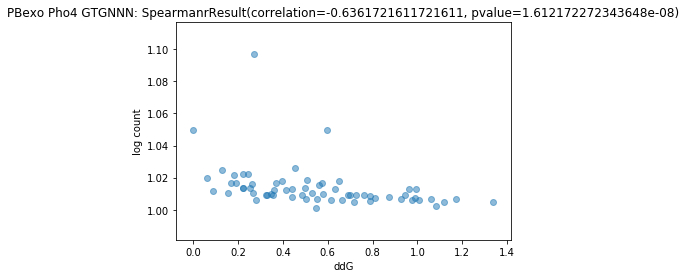

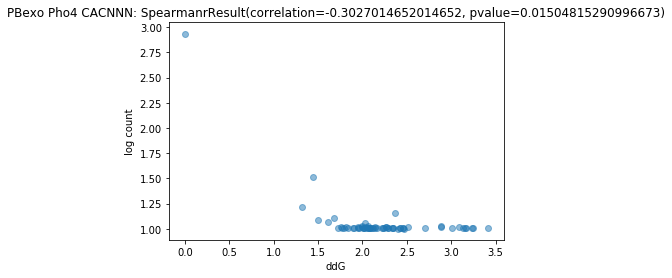

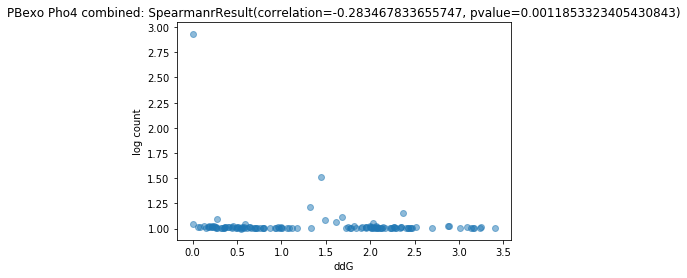

In [20]:
model = pbexo_pho4_model
out_pred_len = 200
seqs = []
x_vals = []
for flank in pho4_GTG_flankToDdG.keys():
    seqs.append(fill_into_center(pbexo_pho4_background, flank))
    x_vals.append(pho4_GTG_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)), np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("PBexo Pho4 GTGNNN: "+str(spearmanr(x_vals, preds)))
plt.show()

seqs = []
x_vals = []
for flank in pho4_CAC_flankToDdG.keys():
    seqs.append(fill_into_center(pbexo_pho4_background, flank))
    x_vals.append(pho4_CAC_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)), np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("PBexo Pho4 CACNNN: "+str(spearmanr(x_vals, preds)))
plt.show()

seqs = []
x_vals = []
for flank in pho4_CAC_flankToDdG.keys():
    seqs.append(fill_into_center(pbexo_pho4_background, flank))
    x_vals.append(pho4_CAC_flankToDdG[flank])
for flank in pho4_GTG_flankToDdG.keys():
    seqs.append(fill_into_center(pbexo_pho4_background, flank))
    x_vals.append(pho4_GTG_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)), np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("PBexo Pho4 combined: "+str(spearmanr(x_vals, preds)))
plt.show()

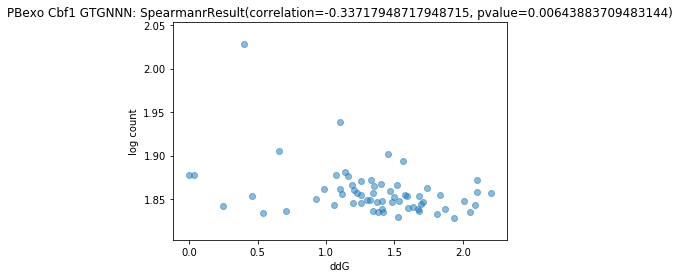

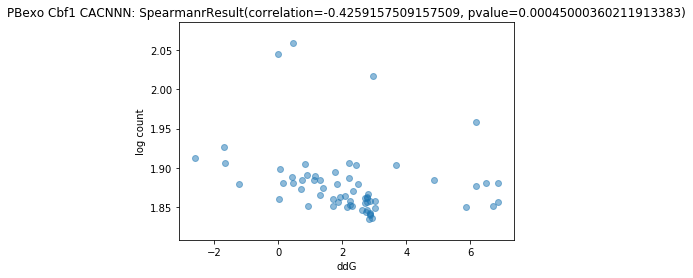

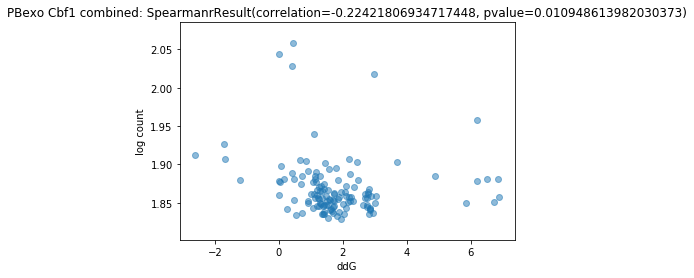

In [21]:
model = pbexo_cbf1_model
out_pred_len = 200
seqs = []
x_vals = []
for flank in cbf1_GTG_flankToDdG.keys():
    seqs.append(fill_into_center(pbexo_cbf1_background, flank))
    x_vals.append(cbf1_GTG_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("PBexo Cbf1 GTGNNN: "+str(spearmanr(x_vals, preds)))
plt.show()

seqs = []
x_vals = []
for flank in cbf1_CAC_flankToDdG.keys():
    seqs.append(fill_into_center(pbexo_cbf1_background, flank))
    x_vals.append(cbf1_CAC_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("PBexo Cbf1 CACNNN: "+str(spearmanr(x_vals, preds)))
plt.show()

seqs = []
x_vals = []
for flank in cbf1_CAC_flankToDdG.keys():
    seqs.append(fill_into_center(pbexo_cbf1_background, flank))
    x_vals.append(cbf1_CAC_flankToDdG[flank])
for flank in cbf1_GTG_flankToDdG.keys():
    seqs.append(fill_into_center(pbexo_cbf1_background, flank))
    x_vals.append(cbf1_GTG_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("PBexo Cbf1 combined: "+str(spearmanr(x_vals, preds)))
plt.show()

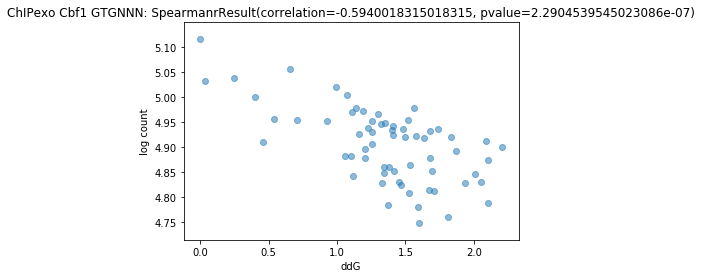

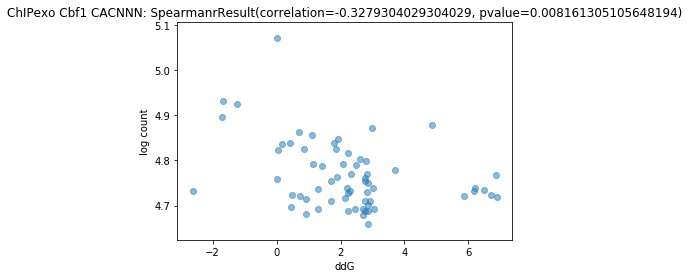

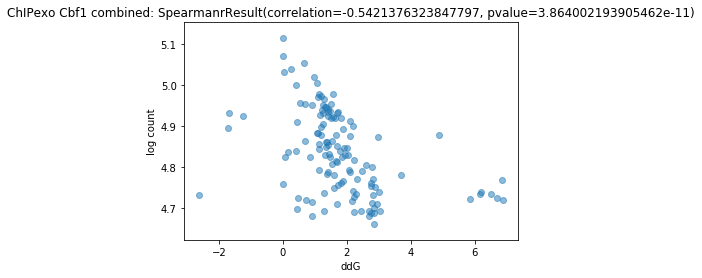

In [22]:
out_pred_len = 225
model = chipexo_cbf1_model
seqs = []
x_vals = []
for flank in cbf1_GTG_flankToDdG.keys():
    seqs.append(fill_into_center(chipexo_cbf1_background, flank))
    x_vals.append(cbf1_GTG_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("ChIPexo Cbf1 GTGNNN: "+str(spearmanr(x_vals, preds)))
plt.show()

seqs = []
x_vals = []
for flank in cbf1_CAC_flankToDdG.keys():
    seqs.append(fill_into_center(chipexo_cbf1_background, flank))
    x_vals.append(cbf1_CAC_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("ChIPexo Cbf1 CACNNN: "+str(spearmanr(x_vals, preds)))
plt.show()

seqs = []
x_vals = []
for flank in cbf1_CAC_flankToDdG.keys():
    seqs.append(fill_into_center(chipexo_cbf1_background, flank))
    x_vals.append(cbf1_CAC_flankToDdG[flank])
for flank in cbf1_GTG_flankToDdG.keys():
    seqs.append(fill_into_center(chipexo_cbf1_background, flank))
    x_vals.append(cbf1_GTG_flankToDdG[flank])
preds = model.predict([getOneHot(seqs), np.zeros((len(seqs),)),
                       np.zeros((len(seqs),out_pred_len,2))])[0]
preds = np.mean(preds, axis=1)
plt.scatter(x_vals, preds, alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("log count")
plt.title("ChIPexo Cbf1 combined: "+str(spearmanr(x_vals, preds)))
plt.show()